In [1]:
import pandas as pd
import numpy as np


In [1]:
from sklearn.naive_bayes import BernoulliNB


In [2]:
NB = BernoulliNB()

This algo works way better with everything 1-hotted, so let's do that


In [3]:
df = pd.read_csv("../data/V2_BPD_CRIME_DATA_ENCODED.csv")

In [4]:
df.head()

,Unnamed: 0,CrimeDate,Description,Neighborhood,Premise,Month,Hour,Outside,Weapon_FIREARM,Weapon_HANDS,Weapon_KNIFE,Weapon_NONE,Weapon_OTHER,Holiday,Weekend
0,0,2017-09-02,11,26,69,9,23,0,0,0,1,0,0,0,1
1,1,2017-09-02,3,213,78,9,23,1,0,0,0,1,0,0,1
2,2,2017-09-02,14,267,78,9,22,1,1,0,0,0,0,0,1
3,3,2017-09-02,0,37,69,9,22,0,0,0,0,0,1,0,1
4,4,2017-09-02,5,63,78,9,22,1,0,1,0,0,0,0,1


In [5]:
df = df.drop(columns=["Unnamed: 0", "CrimeDate"])

In [6]:
Description = pd.read_csv("../data/V2_Description_decoder.csv", header=None)



Actually, we shouldn't need to decode!

In [7]:
df_1hot = pd.get_dummies(df, columns = ['Neighborhood', 'Premise', 'Month', 'Hour'])

In [12]:
df_1hot.shape

(263121, 412)

In [13]:
X = df_1hot.drop(columns = ['Description'])
Y = df_1hot['Description']


In [16]:
from sklearn.model_selection import cross_val_score


In [15]:
scores = cross_val_score(NB, X, Y, cv=5, scoring='f1_macro',n_jobs=-1)
np.mean(scores)


0.4104177895385007

Nice. let's optimize with hyperopt!


In [17]:
import mlflow
import mlflow.sklearn
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

In [22]:
def train_model(params):
    mlflow.sklearn.autolog()
    with mlflow.start_run(nested=True):
        model = BernoulliNB()
        model.set_params(**params)
        model.fit(X,Y)

        mlflow.log_params(params)

        score = cross_val_score(model, X, Y, cv=5, scoring='f1_macro', n_jobs=-1)
        mean_score = np.mean(score)

        mlflow.log_metric('f1_macro', mean_score)

        return {'status': STATUS_OK, 'loss': -1*mean_score, 'booster': model.get_params()}

In [23]:
search_space = {
    'alpha': hp.uniform('alpha', 0, 1),
    'fit_prior': hp.choice("fit_prior",[True,False])
}

In [24]:
with mlflow.start_run(run_name='NB_test'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )


100%|██████████| 20/20 [05:10<00:00, 15.52s/trial, best loss: -0.4171197489280195] 


2021/04/01 18:16:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\mlflow\models\signature.py:123: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2021/04/01 18:16:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\use

Not sure what all those warnings are, but looks like this is much better.

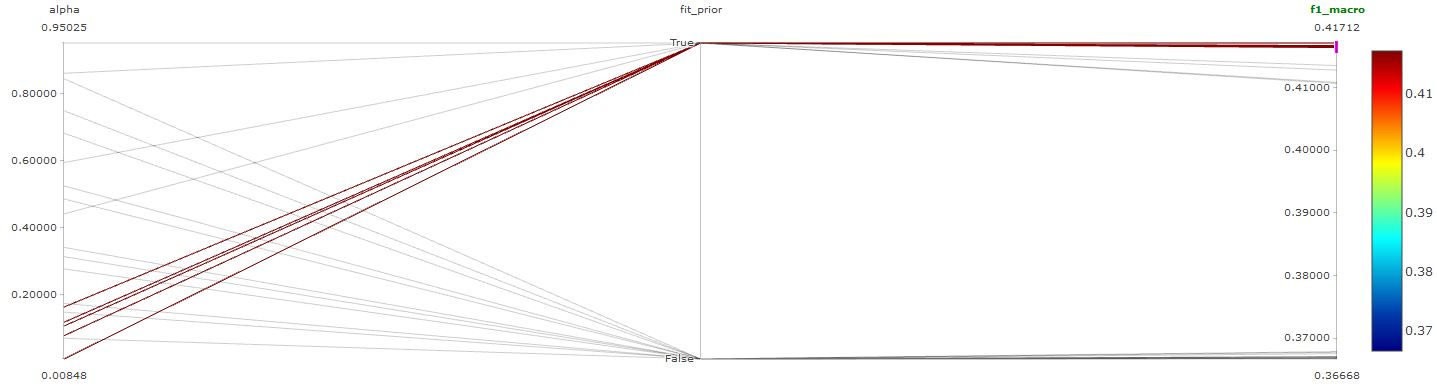

In [27]:
from IPython.display import Image
Image(filename='../images/NB_1.JPG')

In [30]:
search_space = {
    'alpha': hp.uniform('alpha', 0, 0.2),
    'fit_prior': True
}

In [31]:
with mlflow.start_run(run_name='NB_finetune'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )


100%|██████████| 30/30 [07:31<00:00, 15.05s/trial, best loss: -0.4171158486648466] 


2021/04/01 18:38:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\mlflow\models\signature.py:123: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2021/04/01 18:38:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\use

Best one had alpha of 0.008484758202840337


In [32]:
MODEL = BernoulliNB(alpha=0.008484758202840337)

In [33]:
MODEL.fit(X,Y)

2021/04/01 19:30:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6c9830d97dea40979d3f33e158f1d920', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2021/04/01 19:30:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\mlflow\models\signature.py:123: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. 

BernoulliNB(alpha=0.008484758202840337)

In [34]:
import pickle


In [35]:
pickle.dump(MODEL, open("NB_MODEL.sav","wb"))

In [36]:
df2 = pd.read_csv("../data/V2_TEST_DATA_ENCODED_TRANSFORMED.csv")


In [38]:
df2.head()

,Unnamed: 0,CrimeDate,Description,District,Neighborhood,Premise,Month,Hour,Outside,Weapon_FIREARM,Weapon_HANDS,Weapon_KNIFE,Weapon_NONE,Weapon_OTHER,Holiday,Weekend
0,1,2018-12-30,7,3,118,78,12,0,1,0,0,0,1,0,0,1
1,2,2018-12-29,4,0,248,69,12,0,0,0,0,0,1,0,0,1
2,3,2018-12-29,12,2,207,38,12,0,0,0,0,0,1,0,0,1
3,4,2018-12-28,4,6,216,50,12,0,0,0,0,0,1,0,0,0
4,5,2018-12-28,3,4,136,78,12,0,1,0,0,0,1,0,0,0


In [39]:
df2 = df2.drop(columns=["Unnamed: 0","CrimeDate","District"])

In [40]:
df2 = pd.get_dummies(df2, columns = ['Neighborhood', 'Premise', 'Month', 'Hour'])
X_test = df2.drop(columns = ['Description'])
Y_test = df2['Description']


In [42]:
X_test.head()

,Outside,Weapon_FIREARM,Weapon_HANDS,Weapon_KNIFE,Weapon_NONE,Weapon_OTHER,Holiday,Weekend,Neighborhood_0,Neighborhood_1,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
missing = X.columns.difference(X_test.columns)
missing

Index(['Neighborhood_105', 'Neighborhood_14', 'Neighborhood_144',
       'Neighborhood_181', 'Neighborhood_186', 'Neighborhood_233',
       'Neighborhood_263', 'Neighborhood_272', 'Neighborhood_276',
       'Neighborhood_33', 'Neighborhood_47', 'Neighborhood_63',
       'Neighborhood_72', 'Neighborhood_78', 'Neighborhood_9', 'Premise_47',
       'Premise_48', 'Premise_79', 'Premise_8', 'Premise_81', 'Premise_83'],
      dtype='object')

In [51]:
for i in missing:
    X_test[i]=0

In [52]:
predictions = MODEL.predict(X_test)

In [55]:
predictions.shape

(51215,)

In [56]:
from sklearn import metrics

In [57]:
metrics.accuracy_score(predictions,Y_test)

0.2959484526017768

In [58]:
metrics.recall_score(predictions,Y_test,average="weighted",zero_division=0)

0.29594845260177677

In [59]:
metrics.precision_score(predictions,Y_test,average="weighted",zero_division=0)

0.6699025774507913

In [60]:
metrics.f1_score(predictions,Y_test,average="weighted",zero_division=0)

0.3778446224780191

LightGBM still king. Try the onehotencoder


In [8]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
OH = OneHotEncoder(sparse=False, handle_unknown="ignore")


In [11]:
X = df.drop(columns = ['Description'])
Y = df['Description']


In [13]:
OH.fit(X)


OneHotEncoder(handle_unknown='ignore', sparse=False)

In [21]:
X_trans = OH.transform(X)

In [18]:
MODEL = BernoulliNB(alpha=0.008484758202840337)

In [22]:
MODEL.fit(X_trans,Y)

BernoulliNB(alpha=0.008484758202840337)

In [23]:
df2 = pd.read_csv("../data/V2_TEST_DATA_ENCODED_TRANSFORMED.csv")


In [24]:
df2.head()

,Unnamed: 0,CrimeDate,Description,District,Neighborhood,Premise,Month,Hour,Outside,Weapon_FIREARM,Weapon_HANDS,Weapon_KNIFE,Weapon_NONE,Weapon_OTHER,Holiday,Weekend
0,1,2018-12-30,7,3,118,78,12,0,1,0,0,0,1,0,0,1
1,2,2018-12-29,4,0,248,69,12,0,0,0,0,0,1,0,0,1
2,3,2018-12-29,12,2,207,38,12,0,0,0,0,0,1,0,0,1
3,4,2018-12-28,4,6,216,50,12,0,0,0,0,0,1,0,0,0
4,5,2018-12-28,3,4,136,78,12,0,1,0,0,0,1,0,0,0


In [25]:
df2 = df2.drop(columns=["Unnamed: 0","CrimeDate","District"])

In [26]:
X_test = df2.drop(columns = ['Description'])
Y_test = df2['Description']


In [29]:
X_test_trans = OH.transform(X_test)


In [30]:
predictions = MODEL.predict(X_test_trans)

In [31]:
predictions.shape

(51215,)

In [32]:
from sklearn import metrics

In [33]:
metrics.accuracy_score(predictions,Y_test)

0.42184906765596014

In [34]:
metrics.recall_score(predictions,Y_test,average="weighted",zero_division=0)

0.42184906765596014

In [35]:
metrics.precision_score(predictions,Y_test,average="weighted",zero_division=0)

0.6048721486111295

In [36]:
metrics.f1_score(predictions,Y_test,average="weighted",zero_division=0)

0.4606900723197885

Better! but still not as good!